<a href="https://colab.research.google.com/github/tanuja1708/EEG-emotions/blob/main/EEG_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1- Packages**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install ydata-profiling==4.3.1

In [3]:
!pip install scikeras

In [4]:
%matplotlib inline

import warnings
import itertools
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling as pp

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Dropout, BatchNormalization, GRU
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

sns.set_style('dark')

warnings.filterwarnings('ignore')

# **2- Data Preparation & EDA**

In [5]:
df = pd.read_csv('/content/emotions.csv')
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [6]:
# Checking for missing values
for col in df.columns:
    if(df[col].isnull().sum()>0):
        print(col)
# NO missing value

In [8]:
    print(df.shape)

(2132, 2549)


In [9]:
print(df['label'].unique())

['NEGATIVE' 'NEUTRAL' 'POSITIVE']


In [10]:
 print(df.label.value_counts())

label
NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: count, dtype: int64


Classes are almost balanced. We can get away with the difference.
label
NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: count, dtype: int64


<Axes: title={'center': 'Label'}, xlabel='label'>

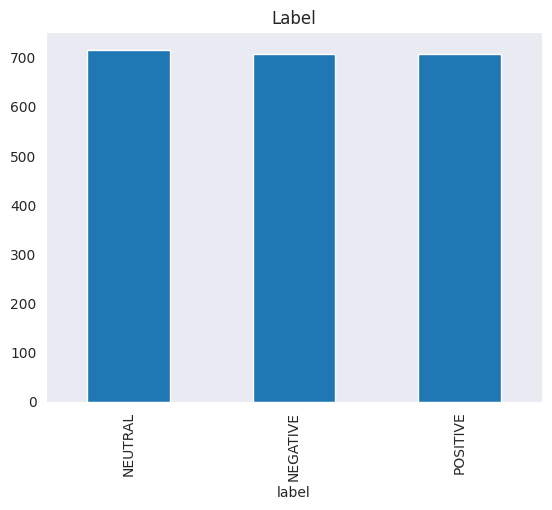

In [11]:
print(f'Classes are almost balanced. We can get away with the difference.\n{df.label.value_counts()}')
df.label.value_counts().plot(kind='bar', color='tab:blue', title='Label')

In [12]:
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.3.1 requires pandas!=1.4.0,<2.1,>1.1, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
bigframes 1.35.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
pymc 5.20.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.


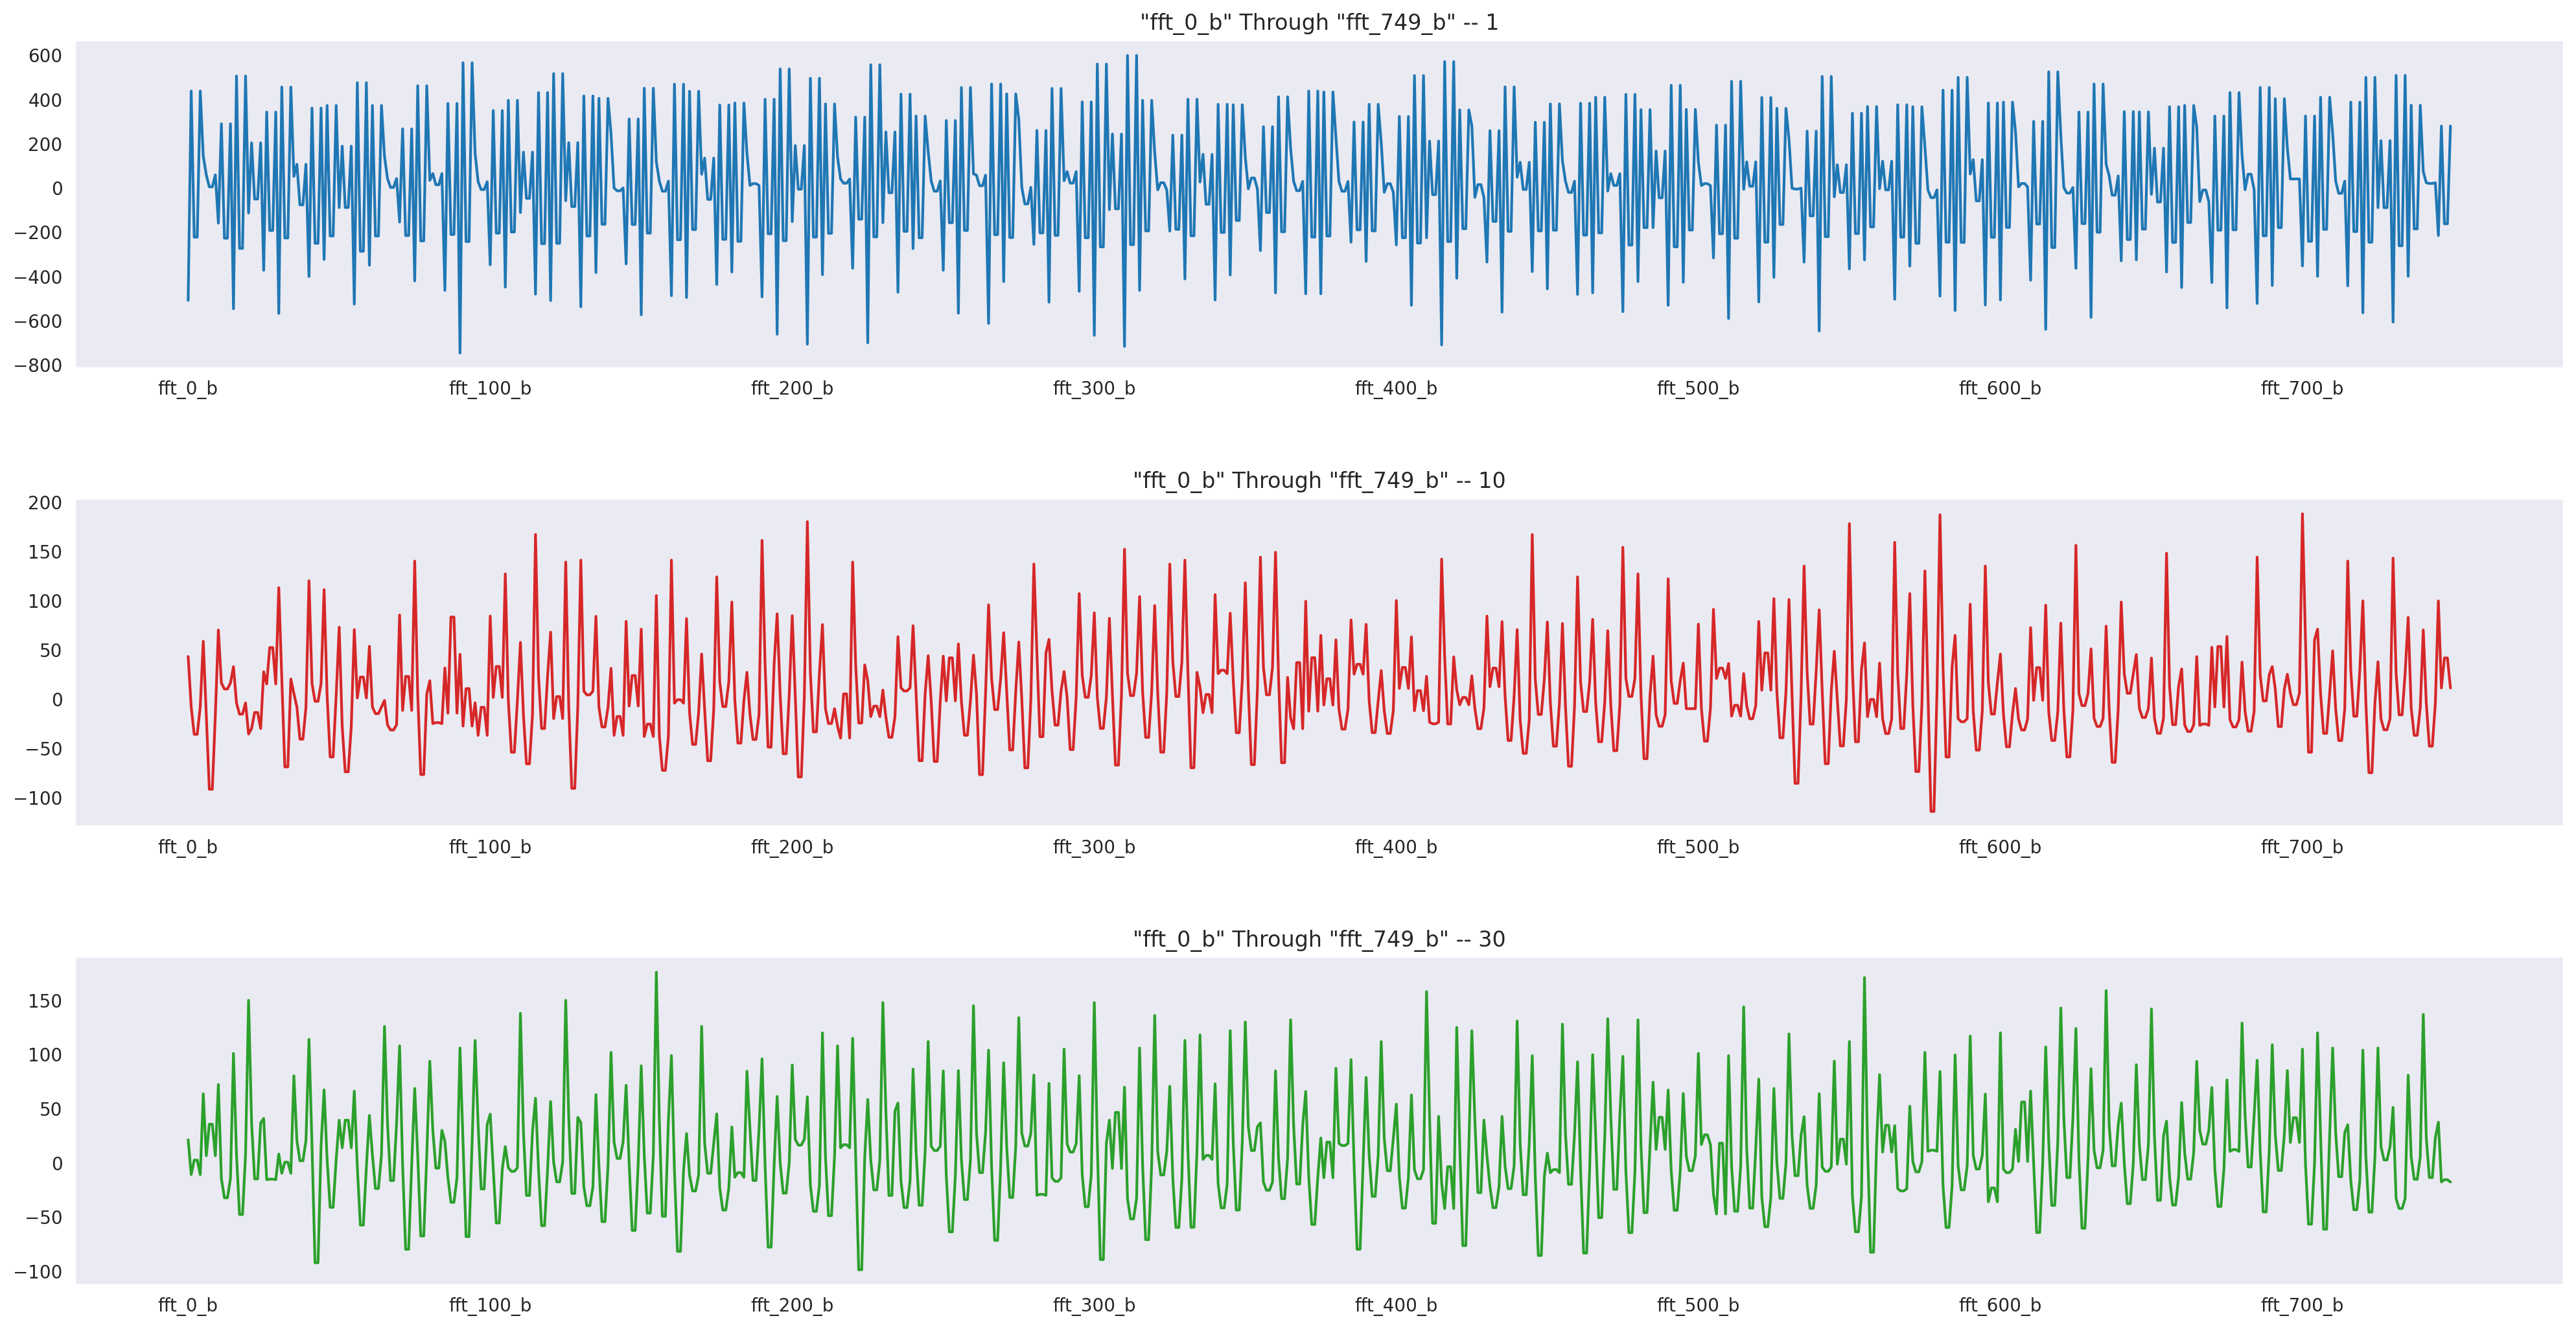

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=200, figsize=(24, 12))

df.loc[0, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 1', color='tab:blue', ax=axes[0])
df.loc[10, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 10', color='tab:red', ax=axes[1])
df.loc[30, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 30', color='tab:green', ax=axes[2])

plt.subplots_adjust(left=0.1, bottom=0.1,
                    right=0.9, top=0.9,
                    wspace=0.4, hspace=0.4)

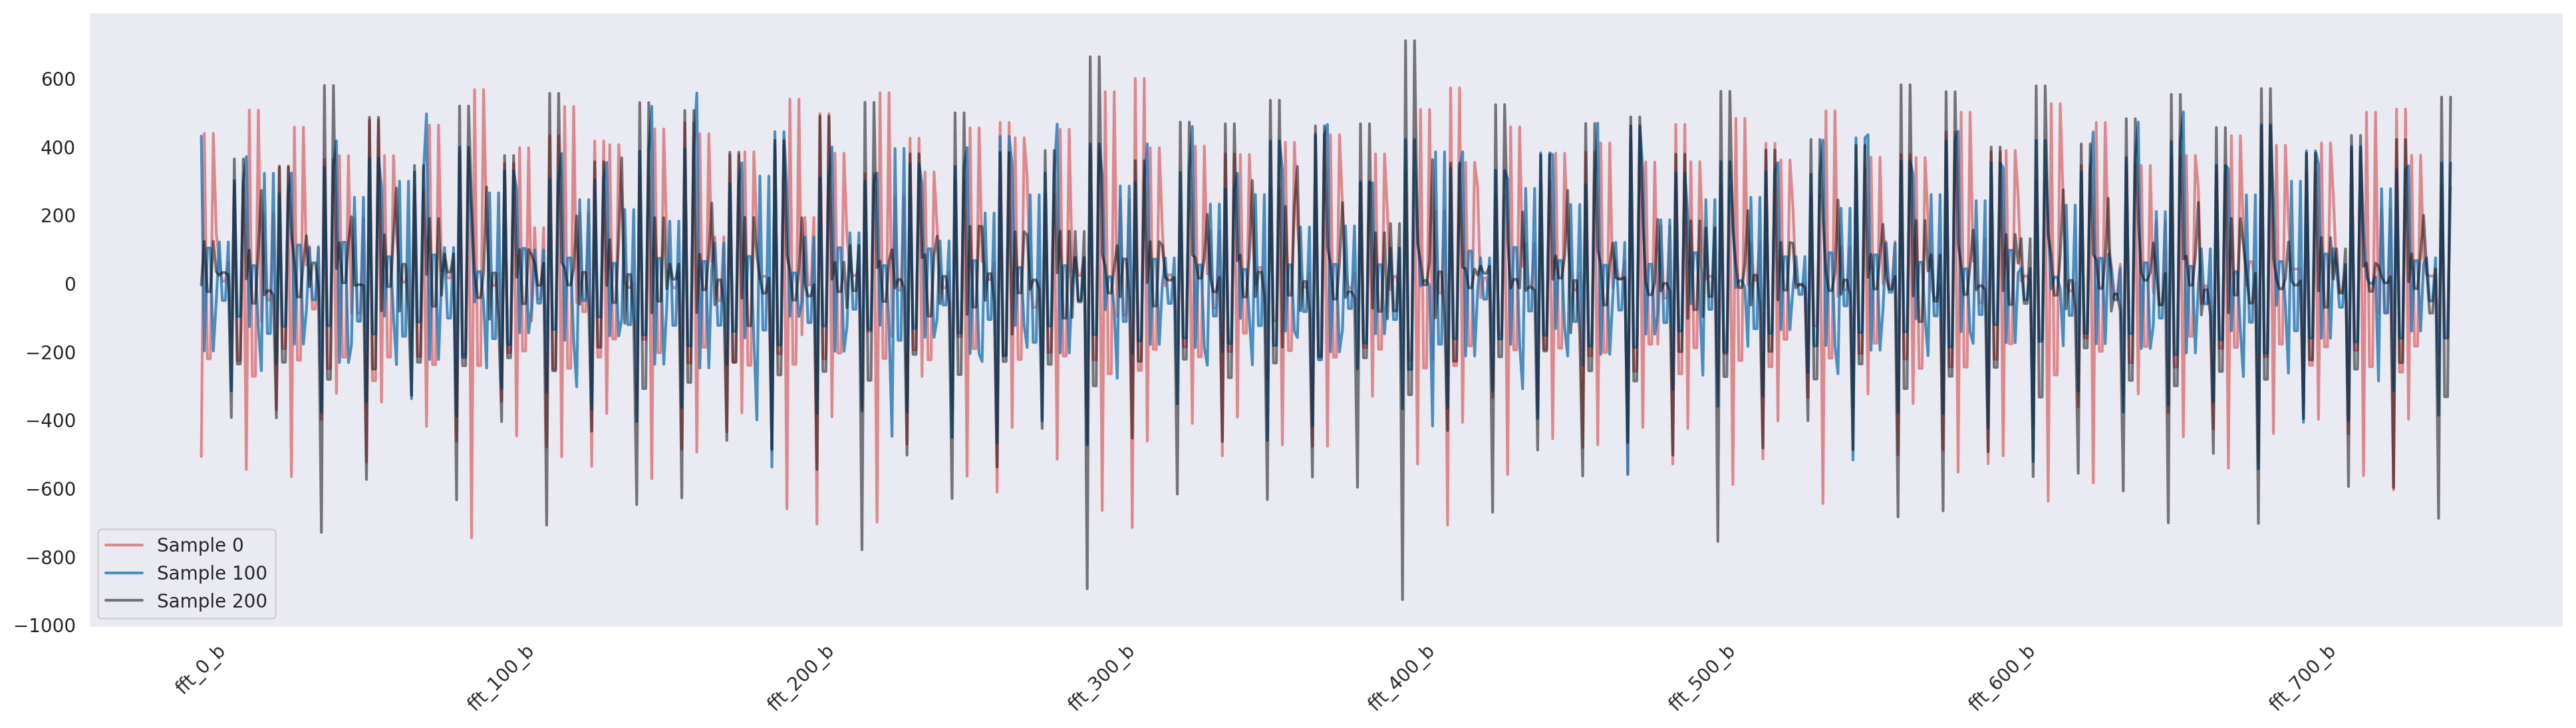

In [14]:
plt.figure(dpi=200, figsize=(24, 6))


plt.plot(df.loc[0, 'fft_0_b':'fft_749_b'], label='Sample 0', color='tab:red', alpha=.5)
plt.plot(df.loc[100, 'fft_0_b':'fft_749_b'], label='Sample 100', color='tab:blue', alpha=.8)
plt.plot(df.loc[200, 'fft_0_b':'fft_749_b'], label='Sample 200', color='black', alpha=.5)


plt.xticks(np.arange(0, len(df.loc[0, 'fft_0_b':'fft_749_b']) + 1, 100), rotation=45)
plt.legend(loc='best')

plt.show()


In [15]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,0
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,1
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,2
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,2
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,1


In [17]:
Y = df['label'].copy()
X = df.drop('label', axis=1).copy()

X_train, x_test, Y_train, y_test = train_test_split(X, Y,random_state=111, test_size=0.3)
X_train, x_val, Y_train, y_val=train_test_split(X_train, Y_train, random_state=111, test_size=0.3)

In [18]:
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1],1))

Y_train = pd.get_dummies(Y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)

# **3- Modeling**

## **3.1 LSTM**

In [19]:
i_lstm = Input(shape=(X_train.shape[1], 1))

x_lstm = LSTM(256, return_sequences=True)(i_lstm)
x_lstm = Flatten()(x_lstm)
y_lstm = Dense(3, activation='softmax')(x_lstm)

model_lstm = Model(i_lstm, y_lstm)

model_lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2548, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 2548, 256)           │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 652288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │       1,956,867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,221,059 (8.47 MB)

 Trainable params: 2,221,059 (8.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_lstm_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

model_lstm.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

lstm_h = model_lstm.fit(X_train, Y_train,
                   batch_size=32,
                   validation_data=(x_val, y_val),
                   epochs=50,
                   callbacks=[es, mc, lr_schedule])

Epoch 1/50
17/33 ━━━━━━━━━━━━━━━━━━━━ 1:55 7s/step - accuracy: 0.6175 - loss: 29.6362

In [3]:
from tensorflow.keras.optimizers import Adam

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

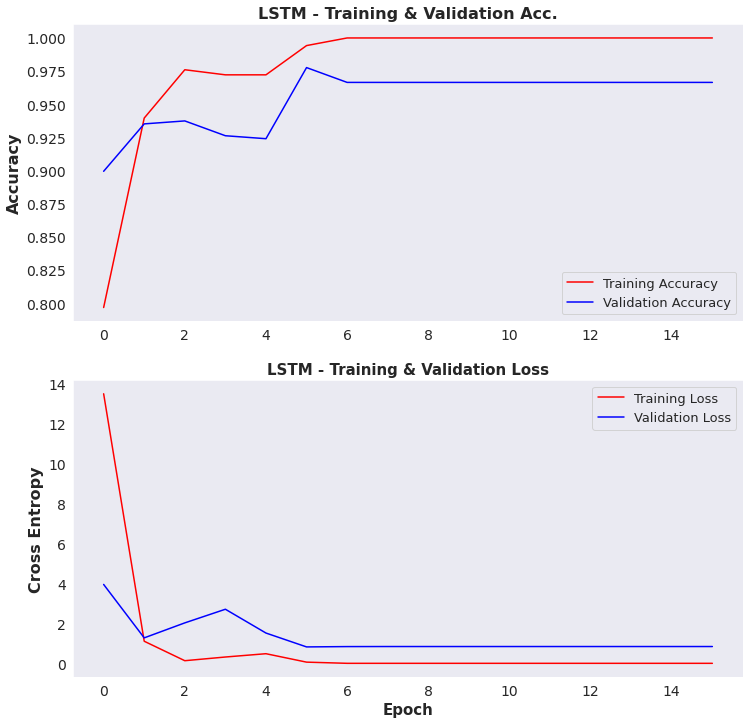

In [ ]:
acc = lstm_h.history['accuracy']
val_acc = lstm_h.history['val_accuracy']

loss = lstm_h.history['loss']
val_loss = lstm_h.history['val_loss']


plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

In [ ]:
lstm_best = load_model('./best_lstm_model.h5')
lstm_acc = lstm_best.evaluate(x_test, y_test, verbose=0)[1]
print("Test Acc.: {:.3f}%".format(lstm_acc * 100))

Test Acc.: 97.500%


In [ ]:
y_pred = np.array(list(map(lambda x: np.argmax(x), lstm_best.predict(x_test))))
y_test = y_test.idxmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       190
           1       1.00      0.98      0.99       231
           2       0.95      0.98      0.96       219

    accuracy                           0.97       640
   macro avg       0.98      0.97      0.97       640
weighted avg       0.98      0.97      0.98       640



Normalized confusion matrix


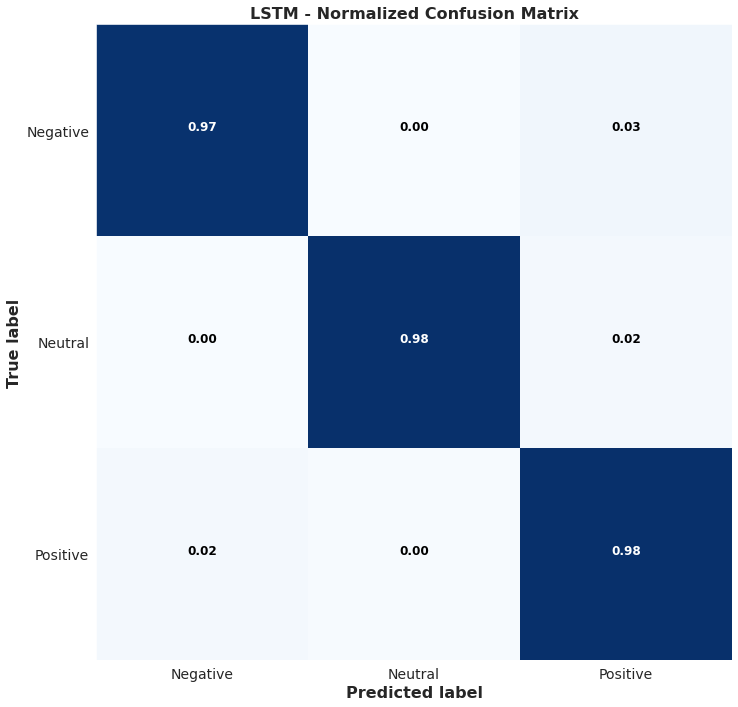

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

cnf_matrix = cm
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'], normalize=True,
                      title='LSTM - Normalized Confusion Matrix')
plt.show()

## **3.2 GRU**

In [ ]:
i_gru = Input(shape=(X_train.shape[1], 1))

x_gru = GRU(256, return_sequences=True)(i_gru)
x_gru = Flatten()(x_gru)
y_gru = Dense(3, activation='softmax')(x_gru)

model_gru = Model(i_gru, y_gru)

model_gru.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2548, 1)]         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 2548, 256)         198912    
_________________________________________________________________
flatten_2 (Flatten)          (None, 652288)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1956867   
Total params: 2,155,779
Trainable params: 2,155,779
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_gru_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

model_gru.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

gru_h = model_gru.fit(X_train, Y_train,
                   batch_size=32,
                   validation_data=(x_val, y_val),
                   epochs=50,
                   callbacks=[es, mc, lr_schedule])

2022-08-01 06:55:30.940955: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
33/33 [==============================] - 7s 172ms/step - loss: 30.4880 - accuracy: 0.7720 - val_loss: 14.7857 - val_accuracy: 0.8884

Epoch 00001: val_accuracy improved from -inf to 0.88839, saving model to ./best_gru_model.h5
Epoch 2/50
33/33 [==============================] - 5s 164ms/step - loss: 9.3174 - accuracy: 0.9071 - val_loss: 7.2312 - val_accuracy: 0.8415

Epoch 00002: val_accuracy did not improve from 0.88839
Epoch 3/50
33/33 [==============================] - 6s 179ms/step - loss: 1.8030 - accuracy: 0.9588 - val_loss: 3.4468 - val_accuracy: 0.9241

Epoch 00003: val_accuracy improved from 0.88839 to 0.92411, saving model to ./best_gru_model.h5
Epoch 4/50
33/33 [==============================] - 5s 161ms/step - loss: 1.0354 - accuracy: 0.9674 - val_loss: 3.6411 - val_accuracy: 0.9330

Epoch 00004: val_accuracy improved from 0.92411 to 0.93304, saving model to ./best_gru_model.h5
Epoch 5/50
33/33 [==============================] - 5s 160ms/step - loss: 1.0231 - acc

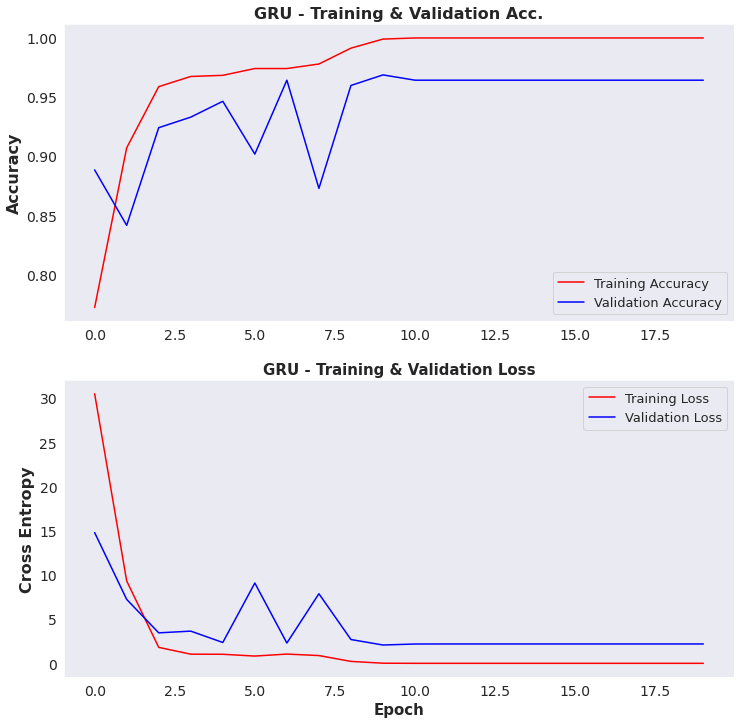

In [ ]:
# Show History
acc = gru_h.history['accuracy']
val_acc = gru_h.history['val_accuracy']

loss = gru_h.history['loss']
val_loss = gru_h.history['val_loss']


plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('GRU - Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('GRU - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

In [ ]:
gru_best = load_model('./best_gru_model.h5')
gru_acc = gru_best.evaluate(x_test, y_test, verbose=0)[1]
print("Test Acc. GRU: {:.3f}%".format(gru_acc * 100))

Test Acc. GRU: 97.188%


In [ ]:
y_pred = np.array(list(map(lambda x: np.argmax(x), gru_best.predict(x_test))))
y_test = y_test.idxmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       190
           1       0.98      0.98      0.98       231
           2       0.96      0.95      0.96       219

    accuracy                           0.97       640
   macro avg       0.97      0.97      0.97       640
weighted avg       0.97      0.97      0.97       640



Normalized confusion matrix


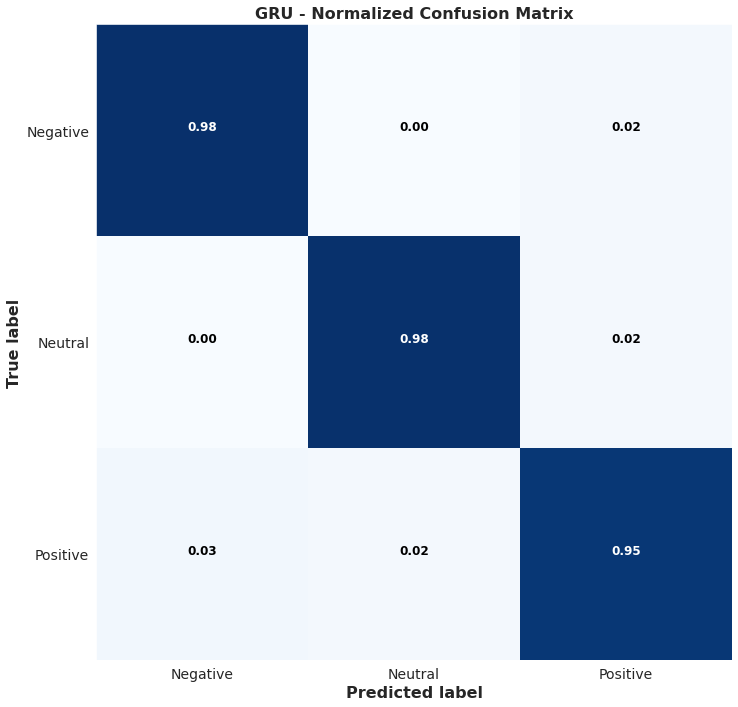

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

cnf_matrix = cm
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'], normalize=True,
                      title='GRU - Normalized Confusion Matrix')
plt.show()

## **3.2 DNN**

In [ ]:
Y = df['label'].copy()
X = df.drop('label', axis=1).copy()

X = StandardScaler().fit_transform(X)

X_train, x_test, Y_train, y_test = train_test_split(X, Y,random_state=111, test_size=0.3)
X_train, x_val, Y_train, y_val=train_test_split(X_train, Y_train, random_state=111, test_size=0.3)

Y_train = pd.get_dummies(Y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)

In [ ]:
i_dnn = Input(shape=(2548, ))

x_dnn = Dense(2548, activation='relu')(i_dnn)
x_dnn = BatchNormalization()(x_dnn)
x_dnn = Dropout(0.25)(x_dnn)

x_dnn = Dense(3822, activation='relu')(x_dnn)
x_dnn = BatchNormalization()(x_dnn)
x_dnn = Dropout(0.27)(x_dnn)

x_dnn = Dense(5096, activation='relu')(x_dnn)
x_dnn = BatchNormalization()(x_dnn)
x_dnn = Dropout(0.3)(x_dnn)

x_dnn = Dense(3822, activation='relu')(x_dnn)
x_dnn = BatchNormalization()(x_dnn)
x_dnn = Dropout(0.27)(x_dnn)

x_dnn = Dense(2548, activation='relu')(x_dnn)
x_dnn = BatchNormalization()(x_dnn)
x_dnn = Dropout(0.25)(x_dnn)

y_dnn = Dense(3, activation='softmax')(x_dnn)

dnn_model = Model(i_dnn, y_dnn)

dnn_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2548)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2548)              6494852   
_________________________________________________________________
batch_normalization (BatchNo (None, 2548)              10192     
_________________________________________________________________
dropout (Dropout)            (None, 2548)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3822)              9742278   
_________________________________________________________________
batch_normalization_1 (Batch (None, 3822)              15288     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3822)              0   

In [ ]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_dnn_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

dnn_model.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

dnn_h = dnn_model.fit(X_train, Y_train,
                   batch_size=32,
                   validation_data=(x_val, y_val),
                   epochs=50,
                   callbacks=[es, mc, lr_schedule])

Epoch 1/50
33/33 [==============================] - 2s 20ms/step - loss: 1.8722 - accuracy: 0.8228 - val_loss: 73.7496 - val_accuracy: 0.5848

Epoch 00001: val_accuracy improved from -inf to 0.58482, saving model to ./best_dnn_model.h5
Epoch 2/50
33/33 [==============================] - 0s 13ms/step - loss: 0.3427 - accuracy: 0.8975 - val_loss: 9.6871 - val_accuracy: 0.8616

Epoch 00002: val_accuracy improved from 0.58482 to 0.86161, saving model to ./best_dnn_model.h5
Epoch 3/50
33/33 [==============================] - 0s 12ms/step - loss: 0.3352 - accuracy: 0.9004 - val_loss: 1.2572 - val_accuracy: 0.8750

Epoch 00003: val_accuracy improved from 0.86161 to 0.87500, saving model to ./best_dnn_model.h5
Epoch 4/50
33/33 [==============================] - 0s 13ms/step - loss: 0.2074 - accuracy: 0.9224 - val_loss: 0.9448 - val_accuracy: 0.8929

Epoch 00004: val_accuracy improved from 0.87500 to 0.89286, saving model to ./best_dnn_model.h5
Epoch 5/50
33/33 [==============================] 

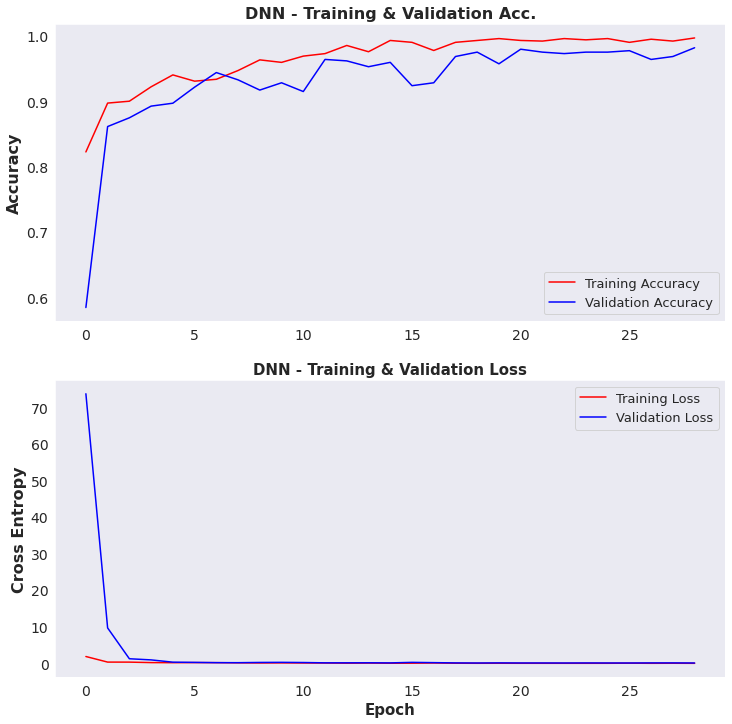

In [ ]:
# Show History
acc = dnn_h.history['accuracy']
val_acc = dnn_h.history['val_accuracy']

loss = dnn_h.history['loss']
val_loss = dnn_h.history['val_loss']


plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('DNN - Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('DNN - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

In [ ]:
dnn_best = load_model('./best_dnn_model.h5')
dnn_acc = dnn_best.evaluate(x_test, y_test, verbose=0)[1]
print("Test Acc. DNN: {:.3f}%".format(dnn_acc * 100))

Test Acc. DNN: 98.438%


In [ ]:
y_pred = np.array(list(map(lambda x: np.argmax(x), dnn_best.predict(x_test))))
y_test = y_test.idxmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       190
           1       0.99      0.99      0.99       231
           2       0.97      0.98      0.98       219

    accuracy                           0.98       640
   macro avg       0.98      0.98      0.98       640
weighted avg       0.98      0.98      0.98       640



Normalized confusion matrix


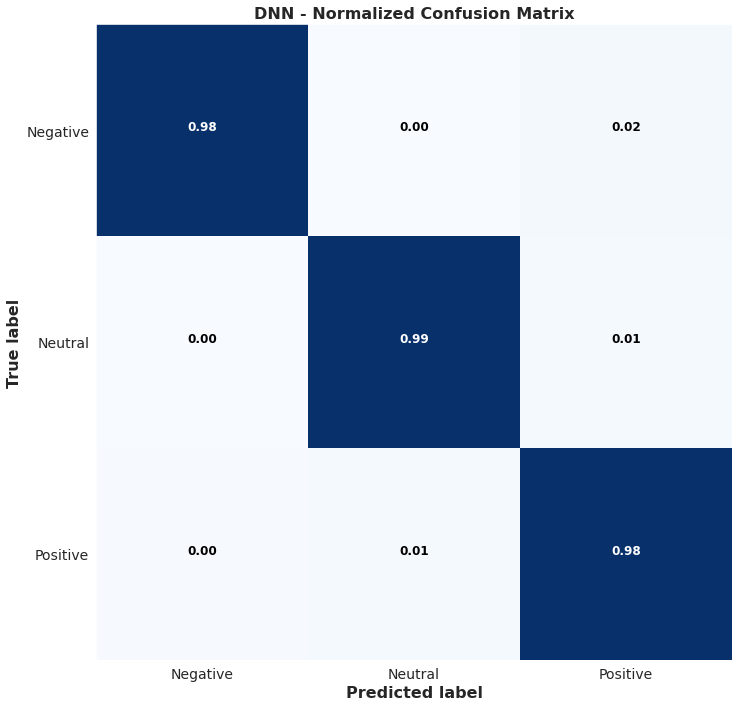

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

cnf_matrix = cm
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'], normalize=True,
                      title='DNN - Normalized Confusion Matrix')
plt.show()

# **4- Conclusion**
**1. In both cases (GRU & LSTM), *val_loss* seems to be stucked in local minima. I'm too lazy to go back and try to fix this, but for the DNN model, I'm going to scale the data just in case. Also, perhaps not all of the 2.5k features are needed, and therefore, using Mutual Information (MI) and choosing the top *N*% features might also improve the performance.**  

**2. The accuracy of models on the test set is as follows:**
 + **DNN: 98.44%**
 + **LSTM: 97.5%**
 + **GRU: 97.18%**

**3. Classification reports suggest that all models managed to generalize well, even though the classes are not perfectly balanced in each set**

**4. Overall, the DNN model offered the best performance. The reason for this might be the fact that I used Z-Score (StandardScaler) for the DNN data. Finally, I believe the performance can also be improved a bit with further data processing and hyperparameter tuning**
